In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
import random
import pickle
from sklearn.preprocessing import StandardScaler
import os
import tensorflow as tf
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

2023-07-23 03:06:35.319045: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-23 03:06:35.321611: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-23 03:06:35.359366: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-23 03:06:35.360165: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 03:06:36.512215: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# with open("..//Data//DeepCDR_DualGCN_combo_run_plot.pickle", "rb") as f: 
#     catch = pickle.load(f)


# # In[ ]:


# all_metrics = []
# all_weights = []
# for i in range(0,50):
#     item = catch[i]
#     metrics = item[:7]
#     weights = item[-8:-4]
#     all_metrics.append(metrics)
#     all_weights.append(weights)

In [3]:

# all_metrics_df = pd.DataFrame(all_metrics)


# # In[ ]:


# all_weights_df = pd.DataFrame(all_weights)


# # In[ ]:


# all_df = pd.concat([all_metrics_df, all_weights_df], axis = 1)


# # In[ ]:


# all_df.columns = ['train_width', 'coverage_train', 'rmse_train', 'test_width', 'coverage_test', 'rmse_test', 'pearson_r', 
#                    "DeepCDR_Drugs", "DeepCDR_Omics", "DualGCN_Drugs", "DualGCN_Omics"]




In [4]:
# # In[ ]:


# all_df.head()


In [5]:


# # In[ ]:


# all_df.mean()


In [6]:


# # In[ ]:


# all_df.std()

In [7]:
warnings.filterwarnings('ignore')

In [8]:
# len(weights_ann_1[0].ravel())

In [9]:
def get_targets_with_weights(batch_data, initial_ensembles, size_ens): 
    
    target_dim = 1
    
    # weights_ann_1 = ann.get_weights()
    
    # h1  = ann.layers[1].output.shape[-1]

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [10]:
def ann(hidden = 32, input_shape = 256, output_shape = 1): 
    input_layer = tf.keras.layers.Input(shape = (input_shape))
    hidden_layer = tf.keras.layers.Dense(hidden)
    hidden_output = hidden_layer(input_layer)
    pred_layer = tf.keras.layers.Dense(output_shape, activation = "relu")
    pred_output = pred_layer(hidden_output)
#     pred_output = tf.keras.layers.Activation("softmax")(pred_output)
    model = tf.keras.models.Model(input_layer, pred_output)
    return model

In [11]:
def generate_initial_ensembles(num_weights, lambda1, size_ens):
    mean_vec = np.zeros((num_weights,))
    cov_matrix = lambda1*np.identity(num_weights)
    mvn_samp = mvn(mean_vec, cov_matrix)
    return mvn_samp.rvs(size_ens)

In [12]:
def expit(x):
    """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
    return 1 / (1 + np.exp(-x))

In [13]:
samp_ann =  ann(hidden = 8, input_shape = 64, output_shape = 1)

In [14]:
weights_ann_1 = samp_ann.get_weights()

In [15]:
h1  = samp_ann.layers[1].output.shape[-1]

In [16]:
h1

8

In [17]:
samp_ann.count_params()

529

In [18]:
hidden_neurons = h1

In [19]:
samp_ann_params = samp_ann.count_params()

In [20]:
def get_initial_X_t(data1, data2, size_ens, var_weights = 1.0, var_weight_weights = 4.0, var_L = 1.0, var_D = 1.0):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    
    initial_ensembles1 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data1_out1, data1_stack1 = get_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens)
    
    initial_ensembles2 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data1_out2, data1_stack2 = get_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens)
    
#     initial_ensembles3 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
#     data2_out1, data2_stack1 = get_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens)
    
#     initial_ensembles4 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
#     data2_out2, data2_stack2 = get_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1)), axis = -1)
    
    initial_ensembles_for_weights = generate_initial_ensembles(2, var_weight_weights, size_ens)
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = generate_initial_ensembles(4, var_L, size_ens)
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)    
    
    initial_ensembles_for_D1 = generate_initial_ensembles(1, var_D, size_ens).reshape(-1,1)
    # initial_ensembles_for_D2 = generate_initial_ensembles(1, var_D, size_ens).reshape(-1,1)
    
    initial_ensembles_for_D1_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
#     initial_ensembles_for_D2_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    
#     initial_ensembles_for_D3_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    
    initial_ensembles_for_D = np.concatenate((np.expand_dims(initial_ensembles_for_D1,1),
                                                       np.expand_dims(initial_ensembles_for_D1_zero,1)), axis = 2)
    
    # print(X_t.shape, initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2))
    
    return X_t, initial_ensembles, initial_ensembles_for_weights[:,0,:], initial_ensembles_for_D[:,0,:]

In [21]:
def get_weighted_targets_with_weights(batch_data, initial_ensembles, size_ens, weights): 
    
    target_dim = 1
    

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    final_output_1 = final_output_1*weights
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [22]:
from scipy.stats import beta

In [23]:
fudging_beta = beta(1,9)

In [24]:
def forward_operation(data1, data2, combined_ensembles , size_ens, fudging_beta):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    params = samp_ann_params
    initial_ensembles1 = combined_ensembles[:, :params]
    initial_ensembles2 = combined_ensembles[:, params:(2*params)]
    # initial_ensembles3 = combined_ensembles[:, (2*params):(3*params)]
    # initial_ensembles4 = combined_ensembles[:, (3*params):(4*params)]

    
    initial_ensembles_for_weights = combined_ensembles[:, (2*params):(2*params + 2)]
    
    # initial_ensembles_for_L = combined_ensembles[:, (4*params + 4):(4*params + 4 + 4)]
    
    initial_ensembles_for_D = combined_ensembles[:,(2*params + 2):(2*params + 2 + 2 )]
    
    
    softmax_weights = tf.math.softmax(initial_ensembles_for_weights).numpy()
    
    model_1 = softmax_weights[:, 0].reshape(-1,1) 
    
    # model_1 = np.min(model_1 -fudging_factor)
    
    model_2 = softmax_weights[:, 1].reshape(-1,1) 
    
#     model_3 = softmax_weights[:, 2].reshape(-1,1) 
    
#     model_4 = softmax_weights[:, 3].reshape(-1,1)
    
    sum_weights = model_1 + model_2
    
    
    # model_1_plus_model_2 = model_1 + model_2
    
    model_1 = model_1/sum_weights
    
    model_2 = model_2/sum_weights
    
#     model_3 = model_3/sum_weights
    
#     model_4 = model_4/sum_weights
    
    
    # print(np.mean(model_1 + model_2))
    
    data1_out1, data1_stack1 = get_weighted_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens,
                                                                  weights=model_1)
    
    data1_out2, data1_stack2 = get_weighted_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens,
                                                                weights=model_2)
    
#     data2_out1, data2_stack1 = get_weighted_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens,
#                                                                  weights=model_3)
    
#     data2_out2, data2_stack2 = get_weighted_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens,
#                                                                   weights=model_4)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1)), axis = -1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2,
                        initial_ensembles_for_weights, initial_ensembles_for_D))
    
    # print(X_t.shape)
    
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)
    
    initial_ensembles_for_D = np.expand_dims(initial_ensembles_for_D,1)
    
    # print(initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    final_output = data1_out1 + data1_out2
    
    # weighted_psa = data1_out2 + data2_out2
    
    return X_t, initial_ensembles,final_output, model_1, model_2

In [25]:
def forward_operation_test(data1, data2, combined_ensembles , size_ens):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    params = samp_ann_params
    initial_ensembles1 = combined_ensembles[:, :params]
    initial_ensembles2 = combined_ensembles[:, params:(2*params)]
    # initial_ensembles3 = combined_ensembles[:, (2*params):(3*params)]
    # initial_ensembles4 = combined_ensembles[:, (3*params):(4*params)]

    
    initial_ensembles_for_weights = combined_ensembles[:, (2*params):(2*params + 2)]
    
    # initial_ensembles_for_L = combined_ensembles[:, (4*params + 4):(4*params + 4 + 4)]
    
    initial_ensembles_for_D = combined_ensembles[:,(2*params + 2):(2*params + 2 + 2)]
    
    
    softmax_weights = tf.math.softmax(initial_ensembles_for_weights).numpy()
    
    model_1 = softmax_weights[:, :1].reshape(-1,1) 
    
    # model_1 = np.min(model_1 -fudging_factor)
    
    model_2 = softmax_weights[:, 1:2].reshape(-1,1) 
    
#     model_3 = softmax_weights[:, 2:3].reshape(-1,1)
    
#     model_4 = softmax_weights[:, 3:4].reshape(-1,1)
    
    sum_weights = model_1 + model_2 
    
    
    # model_1_plus_model_2 = model_1 + model_2
    
    model_1 = model_1/sum_weights
    
    model_2 = model_2/sum_weights
    
#     model_3 = model_3/sum_weights
    
#     model_4 = model_4/sum_weights
    
    data1_out1, data1_stack1 = get_weighted_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens,
                                                                  weights=model_1)
    
    data1_out2, data1_stack2 = get_weighted_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens,
                                                                weights=model_2)
    
#     data2_out1, data2_stack1 = get_weighted_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens,
#                                                                  weights=model_3)
    
#     data2_out2, data2_stack2 = get_weighted_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens,
#                                                                   weights=model_4)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1)), axis = -1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, 
                        initial_ensembles_for_weights, initial_ensembles_for_D))
    
    # print(X_t.shape)
    
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)
    
    initial_ensembles_for_D = np.expand_dims(initial_ensembles_for_D,1)
    
    # print(initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    final_output = data1_out1 + data1_out2 
    
    return X_t, initial_ensembles, final_output, model_1, model_2

In [26]:
total_weights = 2*(samp_ann.count_params() + 1 + 1)

In [27]:
reduction = 10

In [28]:
size_ens = total_weights//reduction
# total_weights//reduction

In [29]:
size_ens

106

In [30]:
G_t = [[1, 1]]
G_t = np.array(G_t).T

In [31]:
G_t.shape

(2, 1)

In [32]:
def get_predictions(data1, data2, initial_ensembles, fudging_beta  =fudging_beta): 
    _,_, weighted_alogp, w1, w2 = forward_operation(data1, data2, initial_ensembles, size_ens = size_ens, fudging_beta = fudging_beta)
    return weighted_alogp, w1, w2

In [33]:
def get_predictions_test(data1, data2, initial_ensembles): 
    _,_, weighted_alogp, w1, w2 = forward_operation_test(data1, data2, initial_ensembles, size_ens = size_ens)
    return weighted_alogp, w1, w2

In [34]:
def calculate_mu_bar_G_bar(data1, data2, initial_ensembles, fudging_beta):
    H_t = np.hstack((np.identity(data1.shape[0]), np.zeros((data1.shape[0], samp_ann_params + 1  + 1))))
    mu_bar = initial_ensembles.mean(0)
    X_t, _,_, _, _ = forward_operation(data1, data2, initial_ensembles, size_ens = size_ens, fudging_beta = fudging_beta)
    X_t = X_t.transpose((0,2,1))
    X_t = X_t.reshape(X_t.shape[0], X_t.shape[1]*X_t.shape[2])
    script_H_t = np.kron(G_t.T, H_t)
    G_u = (script_H_t@X_t.T)
    G_u = G_u.T
    G_bar = (G_u.mean(0)).ravel()
    return mu_bar.reshape(-1,1), G_bar.reshape(-1,1), G_u

In [35]:
def calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u): 
    u_j_minus_u_bar = initial_ensembles - mu_bar.reshape(1,-1)
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    c = np.zeros((total_weights, G_bar.shape[0]))
    for i in range(0, size_ens): 
        c += np.kron(u_j_minus_u_bar[i, :].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return c/size_ens, G_u_minus_G_bar

In [36]:
def calculate_D_u( G_bar, G_u): 
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    d = np.zeros((G_bar.shape[0], G_bar.shape[0]))
    for i in range(0, size_ens): 
        d += np.kron(G_u_minus_G_bar[i,:].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return d/size_ens

In [37]:
def get_updated_ensemble(data1, data2, initial_ensembles, y_train, size_ens = size_ens, inflation_factor = 1.0, fudging_beta = fudging_beta, 
                        fudging_var = None):
    mu_bar, G_bar, G_u = calculate_mu_bar_G_bar(data1, data2, initial_ensembles, fudging_beta)
    C, G_u_minus_G_bar = calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u)
    D = calculate_D_u( G_bar, G_u)
    _, R_t = create_cov(data1.shape[0],initial_ensembles)
    inflation = np.identity(R_t.shape[0])*inflation_factor
    D_plus_cov = D + (R_t *inflation_factor)
    D_plus_cov_inv = np.linalg.inv(D_plus_cov)
    mid_quant = C@D_plus_cov_inv
    noise_vec_mean = np.zeros((R_t.shape[0], ))
    noise_mvn = mvn(noise_vec_mean, R_t)
    fudging = noise_mvn.rvs(size_ens)
    interim = (y_train.T.flatten().reshape(1,-1) + fudging)
    right_quant = interim - G_u
    mid_times_right = mid_quant@right_quant.T
    updated_ensemble = (initial_ensembles + mid_times_right.T)
    if fudging_var is not None: 
        mean_vec = np.zeros((updated_ensemble.shape[1],))
        cov_mat = np.identity(updated_ensemble.shape[1])*fudging_var
        fudging_for_updated_ensembles = mvn(mean_vec, cov_mat)
        fudging_for_updated_ensembles_vec = fudging_for_updated_ensembles.rvs(size_ens)
        updated_ensemble = updated_ensemble + fudging_for_updated_ensembles_vec
    return updated_ensemble

In [38]:
target_dim = 1

In [39]:
lambda_D = 1

In [40]:
from joblib import Parallel, delayed

In [41]:
def create_cov(shape, initial_ensembles):
    cov_part = initial_ensembles[:, -4:-3]
    cov_part = cov_part.mean(0)
    variances1 = tf.math.softplus(cov_part).numpy()
    n = shape
    return variances1, np.identity(n)*variances1

In [42]:
# idx = 1

In [43]:
with open("..//Data//gcn_cdr_train_pca_higher.pickle", "rb") as f: 
    catch_train = pickle.load(f)

In [44]:
with open("..//Data//gcn_cdr_test_pca_higher.pickle", "rb") as f: 
    catch_test = pickle.load(f)

In [45]:
import random

In [46]:
def prepare_data_train(catch_train, idxes): 
    # idxes = random.sample(range(0, catch_train[0].shape[0]), k = size)
    # idxes = list(idxes)
    data1, data2 = catch_train[2][idxes,:], catch_train[3][idxes,:]
    
    y_train = catch_train[-1][idxes].reshape(-1,1)
    
    return data1, data2, y_train 

In [47]:
def prepare_data_test( catch_test, size): 
    idxes = random.sample(range(0, catch_test[0].shape[0]), k = size)
    idxes = list(idxes)
    data1, data2 = catch_test[2][idxes,:], catch_test[3][idxes,:]
    y_train = catch_test[-1][idxes].reshape(-1,1)
    return data1, data2, y_train

In [48]:
# data1_train, data2_train, data3_train, data4_train, y_train =  prepare_data_train(catch_train, size = 5000)

In [49]:
data1_test, data2_test, y_test =  prepare_data_test(catch_test, size = catch_test[0].shape[0])

In [50]:
current_test = [data1_test, data2_test, y_test]

In [51]:
from scipy.stats import pearsonr

In [52]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [53]:
batch_size = 2500

In [54]:
import random

In [55]:
from tqdm import tqdm_notebook

In [56]:
def get_results(idx, var_weights = 1.0, var_weight_weights = 1.0, var_D = 0.01, inflation_factor = 1.6, fudging_beta = beta(1,19), 
               fudging_var = 1e-3, print_true = True):
    
    # smiles_feats_train, rdkit_feats_train, smiles_feats_valid, rdkit_feats_valid, y_train, y_train_actual, y_valid, y_valid_actual, initial_ensembles  = prepare_data(idx, var_weights = var_weights, var_weight_weights =var_weight_weights, var_L = var_L, var_D = var_D)

    w1_catch = []
    w2_catch = []
    train_rmse = []
    test_rmse = []
    # print("done initializing")
    
    train_idxes = random.sample(range(0, catch_train[0].shape[0]), k = catch_train[0].shape[0])
    
    train_chunks = list(chunks(train_idxes, batch_size))
    
    best_rmse_train = 10000
    
    data1_train, data2_train, y_train = prepare_data_train(catch_train, train_chunks[0])
    
    _, initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_D = get_initial_X_t(data1_train, data2_train,
                                                                                                 size_ens = size_ens, var_weights = var_weights,
                                                                                                var_weight_weights = var_weight_weights,
                                                                                                             var_D = var_D)
    
    initial_ensembles = np.hstack((initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_D))
    patience = 0
    
    for i in range(0,300):
        
        train_chunks = random.sample(train_chunks, len(train_chunks))
        
        if print_true == True:
            print("epoch number is " +str(i))
        
        for chunk in (train_chunks):
        
            data1_train, data2_train, y_train = prepare_data_train(catch_train, chunk)
            

            initial_ensembles = get_updated_ensemble(data1_train, data2_train, initial_ensembles, y_train, size_ens = size_ens,
                                                 inflation_factor = inflation_factor, fudging_beta = fudging_beta, fudging_var = fudging_var)
        
            G_u_train, w1, w2 = get_predictions(data1_train, data2_train, initial_ensembles, fudging_beta)
    
            li_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[0,:].reshape(-1,1)    
            ui_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[1,:].reshape(-1,1)  
    
            width_train = ui_train - li_train
            avg_width_train = width_train.mean(0)[0]
    
            ind_train = (y_train >= li_train) & (y_train <= ui_train)
            coverage_train= ind_train.mean(0)[0]
    
            averaged_targets_train = G_u_train.mean(0).reshape(-1,1)
            rmse_train = np.sqrt(((y_train -averaged_targets_train)**2).mean(0))[0]
        
            pearsonr_train = pearsonr(averaged_targets_train.reshape(averaged_targets_train.shape[0],), 
                                 y_train.reshape(y_train.shape[0],))
        
            r_train = pearsonr_train.statistic
    
            G_u_test, _, _ = get_predictions_test(data1_test, data2_test, initial_ensembles)
    

    
            li_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[0,:].reshape(-1,1)     
            ui_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[1,:].reshape(-1,1)   
    
            width_test = ui_test - li_test
            avg_width_test = width_test.mean(0)[0]
    
            ind_test = (y_test >= li_test) & (y_test <= ui_test)
            coverage_test= ind_test.mean(0)[0]
    
            averaged_targets_test = G_u_test.mean(0).reshape(-1,1)
            rmse_test = np.sqrt(((y_test -averaged_targets_test)**2).mean(0))[0]  
        
            pearsonr_test = pearsonr(averaged_targets_test.reshape(averaged_targets_test.shape[0],), 
                                 y_test.reshape(y_test.shape[0],))
        
            r_test = pearsonr_test.statistic
            
            train_rmse.append(rmse_train)
            
            test_rmse.append(rmse_test)
            
            if print_true == True:
                print("Training Coverage, Widths, RMSE, and Pearson R")
                print(coverage_train, avg_width_train, rmse_train, r_train)
                print("Testing Coverage, Widths, RMSE, and Pearson R")
                print(coverage_test, avg_width_test, rmse_test, r_test)
            # print(w1.mean(), w1.std())
            
            w1_catch.append([w1.mean(), w1.std()])
            w2_catch.append([w2.mean(), w2.std()])

            if (rmse_train < best_rmse_train): 
                best_pearsonr_train = r_train
            # print("went here")
                best_train_width_mean = avg_width_train.mean()
                best_train_width = avg_width_train
                # best_smiles_weight = w1.mean()
                best_coverage_train = coverage_train
                best_rmse_train = rmse_train
                best_pearson_r = r_test
                best_test_width = avg_width_test

                best_coverage_test = coverage_test    
                best_rmse_test = rmse_test
                patience = 0
                best_ensembles = initial_ensembles
                best_w1_weight = w1.mean()
                best_w2_weight = w2.mean()
                best_test_preds = averaged_targets_test
                best_li = li_test
                best_ui = ui_test
                best_residuals = (y_test -averaged_targets_test)
                # best_w1_weight
            
            else:
                patience = patience + 1
            
            if print_true == True:
                print("Patience is")
                print(patience)
                print('\n')
        
            if patience > threshold:
            
                # print()
                # print(best_train_width.tolist(), best_coverage_train.tolist(), best_rmse_train.tolist(), best_test_width.tolist(), best_coverage_test.tolist(), best_rmse_test.tolist(), best_smiles_weight, flush = True)
                # print("done for fold" + str(idx), flush = True)
                # print("train_coverage" + str(best_coverage_train), flush = True)
                print("test_coverage" + str(best_coverage_test), flush = True)
                # print("train_width" + str(best_train_width.tolist()), flush = True)
                print("test_width" + str(best_test_width), flush = True)
                # print("smiles_weight" + str(best_smiles_weight), flush = True)
                # print("rmse_train" + str(best_rmse_train.tolist()), flush = True)
                print("rmse_test" + str(best_rmse_test), flush = True)
                weights = [best_w1_weight, best_w2_weight]
                print("weights", flush = True)
                print(weights, flush = True)
                print('\n', flush = True)
                # print("smiles_weight_ci" + str([best_li_smiles_weight, best_ui_smiles_weight]), flush = True)
            
                return [best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r, best_ensembles, train_rmse, test_rmse, best_w1_weight, best_w2_weight, w1_catch, w2_catch, best_test_preds, best_li, best_ui, best_residuals]


In [57]:
threshold = 10

In [58]:
# best_test_preds.shape

In [59]:
%%time
best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r, best_ensembles, train_rmse, test_rmse, \
best_w1_weight, best_w2_weight, w1_catch, w2_catch, best_test_preds, best_li, best_ui, best_residuals = get_results(0, var_weights = 1.0, var_weight_weights = 1.0, var_D = 1, inflation_factor =1, fudging_beta = beta(1,19), 
           fudging_var = 1*1e-2)

epoch number is 0
Training Coverage, Widths, RMSE, and Pearson R
0.2436 20.72248821699762 27.030497668052405 -0.06303635870784974
Testing Coverage, Widths, RMSE, and Pearson R
0.2506930006930007 20.700625855684102 27.0385545040037 -0.08071301300038185
Patience is
0


Training Coverage, Widths, RMSE, and Pearson R
0.4188 6.699186536843034 6.663893367744501 -0.05425597891002297
Testing Coverage, Widths, RMSE, and Pearson R
0.4215176715176715 6.654594447969472 6.655503887615475 -0.04509893113446311
Patience is
0


Training Coverage, Widths, RMSE, and Pearson R
0.7244 5.914408394990775 2.762543246948968 0.5664389976456494
Testing Coverage, Widths, RMSE, and Pearson R
0.7223954723954724 5.874396171505156 2.8347116806357238 0.5670340679342305
Patience is
0


Training Coverage, Widths, RMSE, and Pearson R
0.8456 6.051337616128769 1.9496876025330243 0.7355618133831425
Testing Coverage, Widths, RMSE, and Pearson R
0.8522753522753522 6.055886129395787 1.8956858623839594 0.7485940744119914
Patien

In [60]:
preds_test, _, _ = get_predictions_test(data1_test, data2_test, best_ensembles)

In [61]:
averaged_preds_test = preds_test.mean(0).reshape(-1,1)

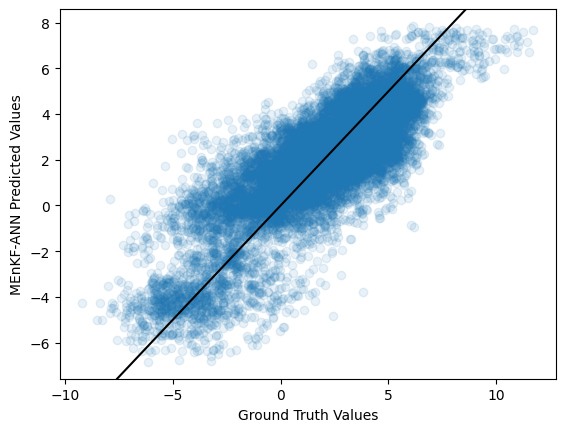

In [62]:
plt.scatter(y_test, averaged_preds_test, alpha = 0.1)
plt.axline((0,0), slope = 1, c = "black")
plt.xlabel("Ground Truth Values")
plt.ylabel("MEnKF-ANN Predicted Values")
# plt.xticks(fontsize = 10, fontweight = "bold")
# plt.yticks(fontsize = 10, fontweight = "bold")
plt.show()

In [63]:
items = [best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r, best_w1_weight, 
        best_w2_weight]

In [64]:
items_df = pd.DataFrame(items).T

In [65]:
items_df.columns = ['best_train_width', 'best_coverage_train', 'best_rmse_train', 'best_test_width', 'best_coverage_test', 'best_rmse_test', 'best_pearson_r', 
                   'best_w1_weight', 'best_w2_weight']

In [66]:
items_df = items_df.T

In [67]:
items_df.columns = ["Value"]

In [68]:
items_df

,Value
best_train_width,6.981878
best_coverage_train,0.933200
best_rmse_train,1.597661
best_test_width,6.919584
best_coverage_test,0.927062
best_rmse_test,1.635246
best_pearson_r,0.816340
best_w1_weight,0.468466
best_w2_weight,0.531534


In [69]:
preds_test.shape

(106, 17316)

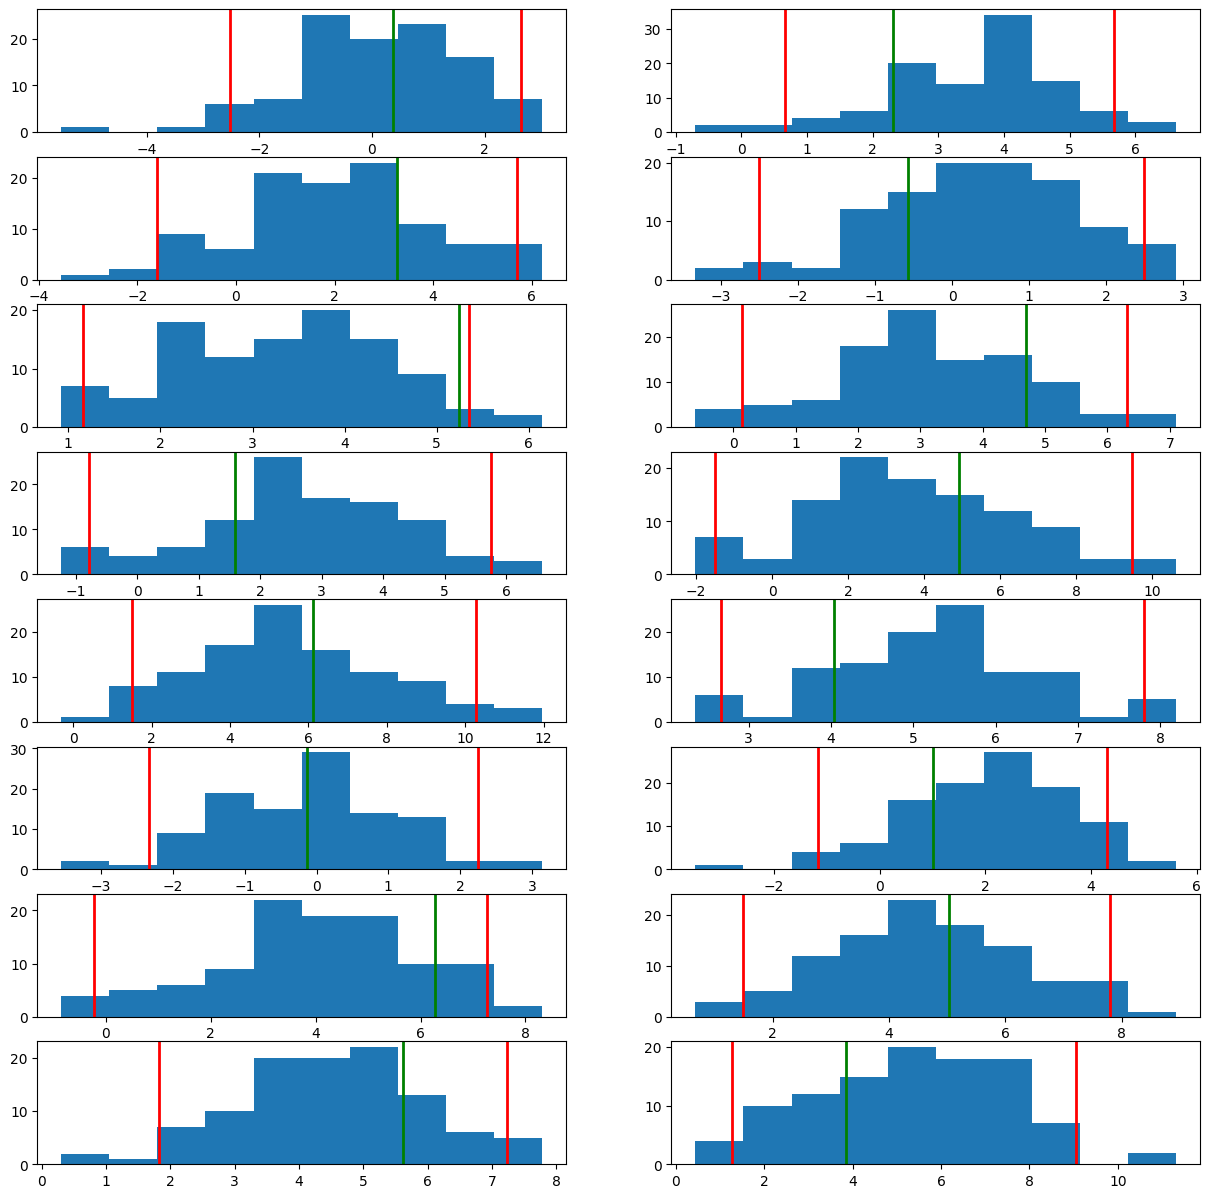

In [70]:
random_idx = random.sample(range(y_test.shape[0]), k = 16)
fig, axs = plt.subplots(8, 2,figsize=(15, 15))
axs = axs.ravel()
for idx, i in enumerate(random_idx):
    # print(counter)
    truth = y_test[i,:]
    preds = preds_test[:, i]
    percts = np.percentile(preds, axis = 0, q = (2.5, 97.5))
    lis = percts[0]
    uis = percts[1]
    
    
    axs[idx].hist(preds)
    axs[idx].axvline(truth, color='green', linewidth=2)
    axs[idx].axvline(lis, color='red', linewidth=2)
    axs[idx].axvline(uis, color='red', linewidth=2)

# plt.title
fig.savefig('gcn_cdr_pred_intervals.png', bbox_inches='tight')
plt.show()


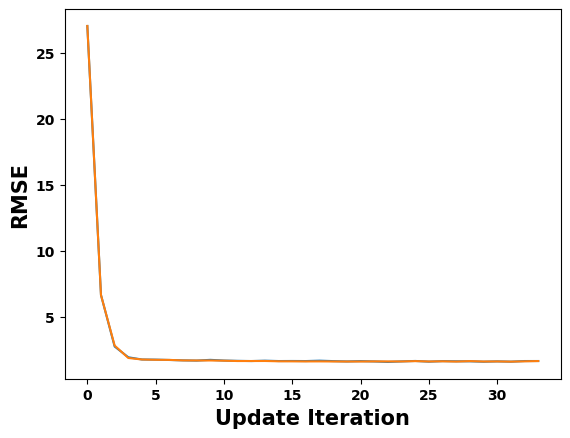

In [71]:
plt.plot(train_rmse)
plt.plot(test_rmse)
plt.xlabel("Update Iteration", fontsize = 15, fontweight = "bold")
plt.ylabel("RMSE", fontsize = 15, fontweight = "bold")
plt.xticks( fontsize = 10, fontweight = "bold")
plt.yticks( fontsize = 10, fontweight = "bold")
plt.show()

In [72]:
# plt.hist(y_train)
# plt.show()

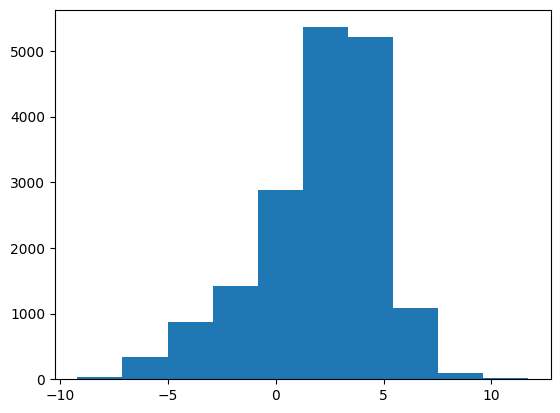

In [73]:
plt.hist(y_test)
plt.show()

In [74]:
catch = Parallel(n_jobs = 14, verbose = 8, backend = "loky")(delayed(get_results)(idx, var_weights = 1.0, var_weight_weights = 1.0, var_D = 1, inflation_factor =1, fudging_beta = beta(1,19), 
           fudging_var = 1*1e-2, print_true = False) for idx in range(0,50))

[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.


test_coverage0.9253291753291754
test_width6.943259573120972
rmse_test1.6558521390006649
weights
[0.3534551541190686, 0.6465448458809315]


test_coverage0.9963039963039964
test_width13.615667435234831
rmse_test1.6809585303951837
weights
[0.16666098470503518, 0.8333390152949648]


test_coverage0.8046315546315547
test_width4.433217797724191
rmse_test1.6559158166620478
weights
[0.49490567181675094, 0.5050943281832492]


test_coverage0.8592053592053592
test_width5.047586123190896
rmse_test1.624181274632958
weights
[0.6327995249512899, 0.36720047504871023]


test_coverage0.8945483945483945
test_width5.634063695173289
rmse_test1.6321480504698633
weights
[0.45980052054271586, 0.5401994794572842]


test_coverage0.6968699468699469
test_width3.4114641046858987
rmse_test1.625042010645317
weights
[0.9038667837358546, 0.09613321626414542]


test_coverage0.732963732963733
test_width3.754594550915974
rmse_test1.61337828423194
weights
[0.8819004381660529, 0.11809956183394717]


test_coverage0.963270963

[Parallel(n_jobs=14)]: Done  13 tasks      | elapsed: 26.4min


test_coverage0.774081774081774
test_width4.337903325058994
rmse_test1.6327180412787803
weights
[0.9905731320057622, 0.009426867994237748]


test_coverage0.7540425040425041
test_width4.077337018941262
rmse_test1.6240662450200443
weights
[0.9501035667880345, 0.049896433211965595]


test_coverage0.9083506583506583
test_width6.8940916781190325
rmse_test1.6283972322257214
weights
[0.2873366866823994, 0.7126633133176006]


test_coverage0.7055902055902056
test_width3.434188277122641
rmse_test1.6222622394213162
weights
[0.9361812863793627, 0.06381871362063732]


test_coverage0.7064564564564565
test_width3.654705618803631
rmse_test1.6571440452556043
weights
[0.9645161783148145, 0.03548382168518545]


test_coverage0.6976206976206977
test_width3.5145902610864126
rmse_test1.6222968970104459
weights
[0.9612207095000185, 0.03877929049998145]


test_coverage0.7057057057057057
test_width3.5411762749533797
rmse_test1.6124138402160062
weights
[0.8833871554992533, 0.1166128445007468]


test_coverage0.771

[Parallel(n_jobs=14)]: Done  30 out of  50 | elapsed: 52.4min remaining: 34.9min


test_coverage0.8395125895125896
test_width4.899979000262688
rmse_test1.631421543497185
weights
[0.5413371848606677, 0.4586628151393322]


test_coverage0.6768306768306769
test_width3.3196643961044145
rmse_test1.6232223251304632
weights
[0.9286801783584104, 0.07131982164158963]


test_coverage0.6705936705936706
test_width3.4627052793992354
rmse_test1.620601019838116
weights
[0.9503662695287053, 0.04963373047129463]


test_coverage0.6232963732963733
test_width3.0328143041173283
rmse_test1.6331407053876679
weights
[0.9369542887935911, 0.06304571120640894]


test_coverage0.9995379995379995
test_width22.06190834840229
rmse_test1.6596511136665952
weights
[0.04015329302580463, 0.9598467069741953]


test_coverage0.9765534765534766
test_width10.35891829921782
rmse_test1.6592465314682212
weights
[0.1894314222158199, 0.8105685777841801]


test_coverage0.8201663201663202
test_width4.739712328550475
rmse_test1.6625749010896806
weights
[0.5278461697583475, 0.47215383024165253]




[Parallel(n_jobs=14)]: Done  37 out of  50 | elapsed: 59.8min remaining: 21.0min


test_coverage0.7732155232155232
test_width4.361077175570383
rmse_test1.6273721930513287
weights
[0.9541731821851599, 0.045826817814840166]


test_coverage0.8420535920535921
test_width4.864018622568342
rmse_test1.6373014056021404
weights
[0.6150177332906018, 0.3849822667093983]


test_coverage0.6391776391776391
test_width3.177626220902896
rmse_test1.6448848719195999
weights
[0.9439615029869856, 0.0560384970130145]


test_coverage0.8288865788865789
test_width4.703244328606167
rmse_test1.6276036148368709
weights
[0.3916828100495548, 0.6083171899504453]


test_coverage0.7404134904134904
test_width3.758480749944813
rmse_test1.6204006982555688
weights
[0.8784497779384113, 0.12155022206158875]


test_coverage0.7427812427812428
test_width3.768674597663573
rmse_test1.6262224006047388
weights
[0.9801335206290479, 0.01986647937095229]


test_coverage0.7417994917994918
test_width3.9608481982188772
rmse_test1.6509602092789932
weights
[0.9449365621609671, 0.05506343783903294]




[Parallel(n_jobs=14)]: Done  44 out of  50 | elapsed: 66.7min remaining:  9.1min


test_coverage0.8660776160776161
test_width5.5620262792712225
rmse_test1.6340227358480175
weights
[0.2970382355670179, 0.7029617644329821]


test_coverage0.7703280203280203
test_width4.065015400937456
rmse_test1.6178151991008494
weights
[0.61760785058834, 0.38239214941166016]


test_coverage0.9965349965349966
test_width15.333095559451083
rmse_test1.7075721913239548
weights
[0.12138269864433614, 0.878617301355664]


test_coverage0.9343959343959344
test_width7.228024981643053
rmse_test1.636238626129431
weights
[0.27499528400285855, 0.7250047159971414]


test_coverage0.817971817971818
test_width4.674831671958951
rmse_test1.616129640049626
weights
[0.8761657874653923, 0.12383421253460779]


test_coverage0.7502310002310002
test_width3.9078414312765535
rmse_test1.628546542769461
weights
[0.8773791455979365, 0.12262085440206352]




[Parallel(n_jobs=14)]: Done  50 out of  50 | elapsed: 75.3min finished


In [75]:
with open("..//Data//DualGCN_run_plots_from_jupyter.pickle", "wb") as f: 
    pickle.dump(catch, f)

In [76]:
with open("..//Data//DualGCN_run_plots_from_jupyter.pickle", "rb") as f: 
    catch = pickle.load(f)

In [83]:
all_metrics = []
all_weights = []
for i in range(0,50):
    item = catch[i]
    metrics = item[:7]
    weights = item[-8:-6]
    all_metrics.append(metrics)
    all_weights.append(weights)
    

In [84]:
all_metrics_df = pd.DataFrame(all_metrics)

In [85]:
all_weights_df = pd.DataFrame(all_weights)

In [86]:
all_df = pd.concat([all_metrics_df, all_weights_df], axis = 1)

In [87]:
all_df.columns = ['train_width', 'coverage_train', 'rmse_train', 'test_width', 'coverage_test', 'rmse_test', 'pearson_r', 
                   "DualGCN_Drugs", "DualGCN_Omics"]

In [88]:
all_df.mean()

train_width       5.901089
coverage_train    0.808939
rmse_train        1.597012
test_width        5.887526
coverage_test     0.798422
rmse_test         1.636904
pearson_r         0.816330
DualGCN_Drugs     0.663470
DualGCN_Omics     0.336530
dtype: float64

In [89]:
all_df.std()

train_width       4.632185
coverage_train    0.103790
rmse_train        0.034404
test_width        4.649194
coverage_test     0.107957
rmse_test         0.024417
pearson_r         0.006169
DualGCN_Drugs     0.321634
DualGCN_Omics     0.321634
dtype: float64

In [90]:
with open("..//Data//DualGCN_run_plot_from_jupyter_test_features_and_ground_truth.pickle", "wb") as f: 
    pickle.dump(current_test, f)

In [91]:
add_preds = np.zeros((y_test.shape[0], y_test.shape[1]))
for item in catch: 
    preds = item[-4]
    add_preds+= preds

In [92]:
averaged_preds = add_preds/50

In [93]:
from sklearn.metrics import mean_squared_error

In [94]:
mse = mean_squared_error(y_test, averaged_preds)

In [95]:
np.sqrt(mse)

1.6040386866584773

In [96]:
from scipy.stats import pearsonr

In [97]:
pearsonr_test = pearsonr(y_test.reshape(y_test.shape[0],), 
                                 averaged_preds.reshape(averaged_preds.shape[0],))

In [98]:
pearsonr_test.statistic

0.8240402138733949

In [99]:
all_li = np.zeros((y_test.shape[0], len(catch)))
all_ui = np.zeros((y_test.shape[0], len(catch)))
for i, item in enumerate(catch): 
    preds = item[-3:-1]
    all_li[:,i] =  preds[0][:,0]
    all_ui[:,i] =  preds[1][:,0]

In [100]:
li = np.median(all_li, axis = 1).reshape(-1,1)

In [101]:
li_mean = np.mean(all_li, axis = 1).reshape(-1,1)

In [102]:
ui = np.median(all_ui, axis = 1).reshape(-1,1)

In [103]:
ui_mean = np.mean(all_ui, axis = 1).reshape(-1,1)

In [104]:
combo = np.hstack((y_test, li, ui))

In [105]:
combo_mean = np.hstack((y_test, li_mean, ui_mean))

In [106]:
combo_mean_df = pd.DataFrame(combo_mean)

In [107]:
combo_mean_df.columns = ["IC50", "LI_IC50_Pred", "UI_IC50_Pred"]

In [108]:
combo_mean_df["coverage"] = (combo_mean_df["IC50"] >= combo_mean_df["LI_IC50_Pred"]) & (combo_mean_df["IC50"] <= combo_mean_df["UI_IC50_Pred"])

In [109]:
combo_mean_df["coverage"].mean()

0.917070917070917

In [110]:
combo_mean_df["width"] = combo_mean_df["UI_IC50_Pred"]-combo_mean_df["LI_IC50_Pred"]

In [111]:
combo_mean_df["width"].mean()

5.8875260227866955

In [112]:
combo_df = pd.DataFrame(combo)

In [113]:
combo_df.columns = ["IC50", "LI_IC50_Pred", "UI_IC50_Pred"]

In [114]:
combo_df = combo_df.sort_values("IC50").reset_index(drop = True)

In [115]:
combo_df["coverage"] = (combo_df["IC50"] >= combo_df["LI_IC50_Pred"]) & (combo_df["IC50"] <= combo_df["UI_IC50_Pred"])

In [116]:
combo_df["coverage"].mean()

0.8014553014553014

In [117]:
combo_df["width"] = combo_df["UI_IC50_Pred"]-combo_df["LI_IC50_Pred"]

In [118]:
combo_df["width"].mean()

4.232527822723568